In [5]:
from src.seq2seq import *
from src.attention import *
from src.utils import *
from src.layers import MaskedCrossEntropyLoss
import torch 
import torch.optim as optim
import random

# Setup

In [6]:
# OPTIONS: 
# ENGLISH - en, 
# GERMAN - de, 
# FRENCH - fr, 
# CZECH - cs

lang1 = 'en'
lang2 = 'en'

train_sentences, test_sentences = load_data(lang1, lang2)
train_sentences = (train_sentences[0][:500], train_sentences[1][:500])

In [7]:
TEST_SIZE=0.2
BATCH_SIZE=64
VALID_BATCH_SIZE=128
MAX_VOCAB=20000

src_vocab, tgt_vocab, train_loader, valid_loader = make_dataset(train_sentences, test_sentences, BATCH_SIZE, VALID_BATCH_SIZE, MAX_VOCAB)

In [8]:
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(valid_loader.dataset)}")
print(f"Training Batches {len(train_loader)}\tValidation Batches {len(valid_loader)}")

Number of training examples: 500
Number of validation examples: 1014
Training Batches 8	Validation Batches 8


In [9]:
print(f"Unique tokens in source ({lang1}) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target ({lang2}) vocabulary: {len(tgt_vocab)}")

Unique tokens in source (en) vocabulary: 1224
Unique tokens in target (en) vocabulary: 1224


# Make the Model

In [10]:
# ENCODER ARGS
ENC_UNITS = 128
ENC_EMBEDDING = 128
SRC_VOCAB_SIZE = len(src_vocab)
ENC_NUM_LAYERS = 1

# ATTENTION DECODER ARGS
DEC_UNITS = ENC_UNITS
DEC_EMBEDDING = ENC_EMBEDDING
TGT_VOCAB_SIZE = len(tgt_vocab)
DEC_NUM_LAYERS = ENC_NUM_LAYERS
'''
Choices = [
    ConcatAttention, GeneralAttention, 
    DotAttention, MeanAttention, LastInSeqAttention
]
'''
ATTN_LAYER = ConcatAttention
ATTN_HIDDEN_SIZE = 512

# SEQ2SEQ ARGS
TEACHER_FORCING = 0.
MAX_LENGTH = train_loader.dataset.tensors[1].size(-1) + 1
SOS_TOKEN = tgt_vocab.SOS_token

In [11]:
encoder = Encoder(ENC_UNITS, ENC_EMBEDDING, SRC_VOCAB_SIZE, ENC_NUM_LAYERS)
decoder = AttentionDecoder(DEC_UNITS, DEC_EMBEDDING, TGT_VOCAB_SIZE, DEC_NUM_LAYERS, ATTN_LAYER, ATTN_HIDDEN_SIZE)

seq2seq = Seq2Seq(encoder, decoder, TEACHER_FORCING, MAX_LENGTH, SOS_TOKEN)

print(f'The model has {count_parameters(seq2seq):,} trainable parameters')

The model has 850,632 trainable parameters


In [12]:
print(seq2seq)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1224, 128)
    (gru): GRU(128, 128, batch_first=True)
  )
  (decoder): AttentionDecoder(
    (embedding): Embedding(1224, 128)
    (gru): GRU(256, 128, batch_first=True)
    (attention): ConcatAttention(
      (W_a): Linear(in_features=256, out_features=512, bias=True)
      (v_a): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc): Linear(in_features=128, out_features=1224, bias=True)
  )
)


In [13]:
criterion = MaskedCrossEntropyLoss(pad_tok=tgt_vocab.PAD_token)
optimizer = optim.Adam(seq2seq.parameters())

# Train

In [300]:
valid_loss = evaluate(seq2seq, valid_loader, criterion)


100%|██████████| 8/8 [00:07<00:00,  1.20it/s]

In [301]:
valid_loss

3.964473694562912

In [259]:
seq2seq.teacher_forcing = 0.

N_EPOCHS = 100
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    
    train_loss = train(seq2seq, train_loader, optimizer, criterion, CLIP, src_vocab.PAD_token)
#     valid_loss = evaluate(seq2seq, valid_loader, criterion)
    valid_loss = evaluate(seq2seq, train_loader, criterion)



    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(seq2seq.state_dict(), 'models/seq2seq_attention.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01
100%|██████████| 8/8 [00:04<00:00,  1.99it/s]
	Train Loss: 0.021 | Train PPL:   1.021
	 Val. Loss: 0.020 |  Val. PPL:   1.020
Epoch: 02
100%|██████████| 8/8 [00:04<00:00,  2.09it/s]
	Train Loss: 0.020 | Train PPL:   1.020
	 Val. Loss: 0.019 |  Val. PPL:   1.020
Epoch: 03
100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
	Train Loss: 0.019 | Train PPL:   1.020
	 Val. Loss: 0.019 |  Val. PPL:   1.019
Epoch: 04
100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
	Train Loss: 0.019 | Train PPL:   1.019
	 Val. Loss: 0.019 |  Val. PPL:   1.019
Epoch: 05
100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
	Train Loss: 0.018 | Train PPL:   1.019
	 Val. Loss: 0.018 |  Val. PPL:   1.018
Epoch: 06
100%|██████████| 8/8 [00:03<00:00,  2.16it/s]
	Train Loss: 0.018 | Train PPL:   1.018
	 Val. Loss: 0.018 |  Val. PPL:   1.018
Epoch: 07
100%|██████████| 8/8 [00:03<00:00,  2.10it/s]
	Train Loss: 0.018 | Train PPL:   1.018
	 Val. Loss: 0.017 |  Val. PPL:   1.018
Epoch: 08
100%|██████████| 8/8 [00:03<00:00,  2.

KeyboardInterrupt: 

In [302]:
idx = 777

src_sentence = valid_loader.dataset.tensors[0][idx:idx+1]
tgt_sentence = valid_loader.dataset.tensors[1][idx:idx+1]

print(src_sentence.size(), tgt_sentence.size())

src_sentence = src_vocab.to_string(src_sentence, remove_special=True)[0]
tgt_sentence = tgt_vocab.to_string(tgt_sentence, remove_special=True)[0]

torch.Size([1, 32]) torch.Size([1, 32])


In [303]:
translation, attention = translate(src_sentence, seq2seq, src_vocab, tgt_vocab, src_vocab.PAD_token)

tensor([[   3,    2,   29,    6,    2,   27,  376,   13,    1,  166,   28,    1,
            1,   28, 1070,  512,   13,  107,   19,   89,    5,    4]])
tensor([[  43,   13,   69,  166,   28, 1087,  396,   28, 1206,  374,  374,   15,
            5,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4]])


In [304]:
print(f"> {src_sentence}")
print(f"= {tgt_sentence}")
print(f"< {translation}")

> a girl in a black tank with <unk> shorts to <unk> <unk> to be dancing with several people around .
= a girl in a black tank with <unk> shorts to <unk> <unk> to be dancing with several people around .
< three with one shorts to perform others to leap who who are .


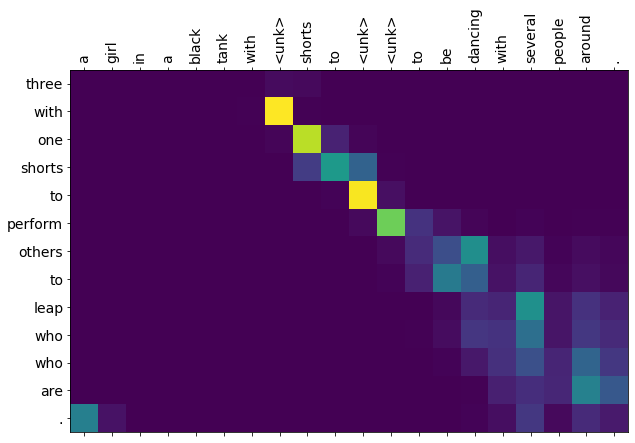

In [305]:
plot_attention(attention, src_sentence, translation)